### Импорт пакетов

In [82]:
import requests
import json

import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch, FontManager
from matplotlib import rcParams

import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Получаем данные из CSV

In [83]:
df_events = pd.read_csv('all_data.csv', index_col=0)
df_events.columns

Index(['id', 'matchId', 'matchPeriod', 'minute', 'second', 'matchTimestamp',
       'videoTimestamp', 'relatedEventId', 'shot', 'groundDuel', 'aerialDuel',
       'infraction', 'carry', 'type_primary', 'type_secondary', 'location_x',
       'location_y', 'team_id', 'team_name', 'team_formation',
       'opponentTeam_id', 'opponentTeam_name', 'opponentTeam_formation',
       'player_id', 'player_name', 'player_position', 'pass_accurate',
       'pass_angle', 'pass_height', 'pass_length', 'pass_recipient_id',
       'pass_recipient_name', 'pass_recipient_position', 'pass_endLocation_x',
       'pass_endLocation_y', 'possession_id', 'possession_duration',
       'possession_types', 'possession_eventsNumber', 'possession_eventIndex',
       'possession_startLocation_x', 'possession_startLocation_y',
       'possession_endLocation_x', 'possession_endLocation_y',
       'possession_team_id', 'possession_team_name',
       'possession_team_formation', 'possession_attack', 'pass',
       'aeri

In [84]:
df_events['team_name'].unique()

array(['Lokomotiv Moskva', 'Spartak Moskva', 'Nizhny Novgorod',
       'Akhmat Grozny', 'Rostov', "Rubin Kazan'", 'Ural', 'Zenit',
       'CSKA Moskva', 'Sochi', 'Krylya Sovetov', 'Khimki',
       'Dinamo Moskva', 'Krasnodar', 'Arsenal Tula', 'Ufa'], dtype=object)

### Фильтруем данные и выбираем команду, по которой будем выполнять анализ

In [85]:
team = 'Sochi'
mask_team = (df_events['type_primary'] == 'pass') & \
            (df_events['type_secondary'].str.contains('progressive_pass', regex=False)) & \
            (df_events['pass_accurate'] == True) & \
            (df_events['team_name'] == team)
df_clear_data = df_events.loc[
    mask_team, 
    ['id', 'matchId', 
     'location_x', 'location_y', 'team_id', 'team_name', 
     'pass_endLocation_x', 'pass_endLocation_y', 'pass_length', 'pass_angle']
]

In [86]:
df_clear_data.rename(columns={'location_x': 'x', 'location_y': 'y', 'pass_endLocation_x': 'endX', 'pass_endLocation_y': 'endY'}, inplace=True)
df_clear_data

,id,matchId,x,y,team_id,team_name,endX,endY,pass_length,pass_angle
6968,1104192439,5228841,45.0,11.0,14286,Sochi,60.0,23.0,18.0,29.0
6977,1104192447,5228841,67.0,34.0,14286,Sochi,77.0,41.0,12.0,24.0
6994,1104192456,5228841,81.0,93.0,14286,Sochi,80.0,63.0,20.0,-93.0
7044,1104192481,5228841,46.0,18.0,14286,Sochi,80.0,81.0,56.0,50.0
7075,1104192500,5228841,41.0,48.0,14286,Sochi,61.0,64.0,24.0,28.0
...,...,...,...,...,...,...,...,...,...,...
179733,974019803,5228739,71.0,34.0,14286,Sochi,90.0,45.0,21.0,22.0
179778,974019849,5228739,43.0,5.0,14286,Sochi,65.0,8.0,23.0,5.0
179779,974019852,5228739,65.0,8.0,14286,Sochi,81.0,30.0,23.0,41.0
179795,974019871,5228739,33.0,68.0,14286,Sochi,68.0,41.0,41.0,-27.0


## Кластерный анализ

### Метод локтя
Вычисляем, какое количество кластеров использовать

In [87]:
# Elbow Method: determining how many clusters to use in the final plots
# K = range(100,220)
# wss= []
# for k in K:
#     array = np.array(df_clear_data[['x', 'y', 'endX', 'endY', 'pass_length']])
#     kmeans = KMeans(n_clusters = k, random_state = 100)
#     kmeans.fit(array)
#     wss_iter = kmeans.inertia_
#     wss.append(wss_iter)
    
# mycenters = pd.DataFrame({'Clusters':K, 'WSS':wss})
# mycenters

In [88]:
# Reading the results of the Elbow Method: imagine the shape created
# by this scatter plot as one of an arm. The part best-resembling an elbow
# is considered the "ideal" amount of clusters to use
# plt.scatter(x=mycenters['Clusters'], y=mycenters['WSS'])

### Нормализация
Приводим данные, которые участвуют в кластеризации к диапазону [0..1]

In [89]:
features = df_clear_data[['x', 'y', 'endX', 'endY', 'pass_length', 'pass_angle']]
scaler = StandardScaler()
df_clear_data[['x', 'y', 'endX', 'endY', 'pass_length', 'pass_angle']] = scaler.fit_transform(features)

In [90]:
df_clear_data.x.count()

877

### Кластеризация
Добавляем колонку cluster в dataframe

In [91]:
num_of_clusters = int(df_clear_data.x.count() / 5)
model = KMeans(n_clusters=num_of_clusters, random_state = 100)
data = df_clear_data[['x', 'y', 'endX', 'endY', 'pass_length', 'pass_angle']]
model.fit(data)

df_clear_data['cluster'] = model.labels_

In [92]:
popular_clusters = df_clear_data.cluster.value_counts().index.tolist()[0:7]
df_clear_data.cluster.value_counts().head(10)

104    11
32     11
97     10
66     10
71     10
110    10
84     10
53     10
95      9
10      9
Name: cluster, dtype: int64

### Рисуем поле и визуализируем кластеры передач

#### Функция получения progressive passes из dataframe

In [93]:
def progressive_passes_for_team(df_events, team):
    mask_team = (df_events['type_primary'] == 'pass') & \
                (df_events['type_secondary'].str.contains('progressive_pass', regex=False)) & \
                (df_events['pass_accurate'] == True) & \
                (df_events['team_name'] == team)
    df_clear_data = df_events.loc[
        mask_team, 
        ['id', 'matchId', 
         'location_x', 'location_y', 'team_id', 'team_name', 
         'pass_endLocation_x', 'pass_endLocation_y', 'pass_length', 'pass_angle']
    ]
    df_clear_data.rename(columns={'location_x': 'x', 'location_y': 'y', 'pass_endLocation_x': 'endX', 'pass_endLocation_y': 'endY'}, inplace=True)
    return df_clear_data

#### Функция кластеризации

In [98]:
def cluster_passes(df_clear_data, num_pop_clusters):
    # Normalizing
    features = df_clear_data[['x', 'y', 'endX', 'endY', 'pass_length', 'pass_angle']]
    scaler = StandardScaler()
    df_clear_data[['x_norm', 'y_norm', 'endX_norm', 'endY_norm', 'pass_length_norm', 'pass_angle_norm']] = scaler.fit_transform(features)
    
    # Clustering
    num_of_clusters = int(df_clear_data.x.count() / 5)
    model = KMeans(n_clusters=num_of_clusters, random_state = 100)
    data = df_clear_data[['x_norm', 'y_norm', 'endX_norm', 'endY_norm', 'pass_length_norm', 'pass_angle_norm']]
    model.fit(data)
    
    df_clear_data['cluster'] = model.labels_
    
    popular_clusters = df_clear_data.cluster.value_counts().index.tolist()[0:num_pop_clusters]
    return df_clear_data, popular_clusters

#### Функция, которая рисует пасы по 1 команде

In [95]:
def draw_progressive_passes_for_team(df_events, team, team_color, pitch, ax, num_pop_clusters=7):
    df_passes = progressive_passes_for_team(df_events, team)
    df_passes, popular_clusters = cluster_passes(df_passes, num_pop_clusters)
    for x in range(len(popular_clusters)):
        df_cluster_passes = df_passes[df_passes['cluster'] == popular_clusters[x]]
#         print(f"Cluster: {popular_clusters[x]}. Number of passes: {df_cluster_passes.x.count()}")
        pitch.arrows(
            df_cluster_passes.x.mean(), df_cluster_passes.y.mean(),
            df_cluster_passes.endX.mean(), df_cluster_passes.endY.mean(), 
            width=2, headwidth=5, headlength=5, color=team_color, ax=ax)
        pitch.lines(
            df_cluster_passes['x'], df_cluster_passes['y'],
            df_cluster_passes['endX'], df_cluster_passes['endY'], 
            lw = 1, zorder=1, color=team_color, alpha=.2, ax=ax)
    
    # Set the title of the pitch
    ax.set_title(f'{team}', color=team_color, fontsize=30)

Text(0.5, 0.3, 'РПЛ. Матчи первых 14 туров\nТоп 7 кластеров')

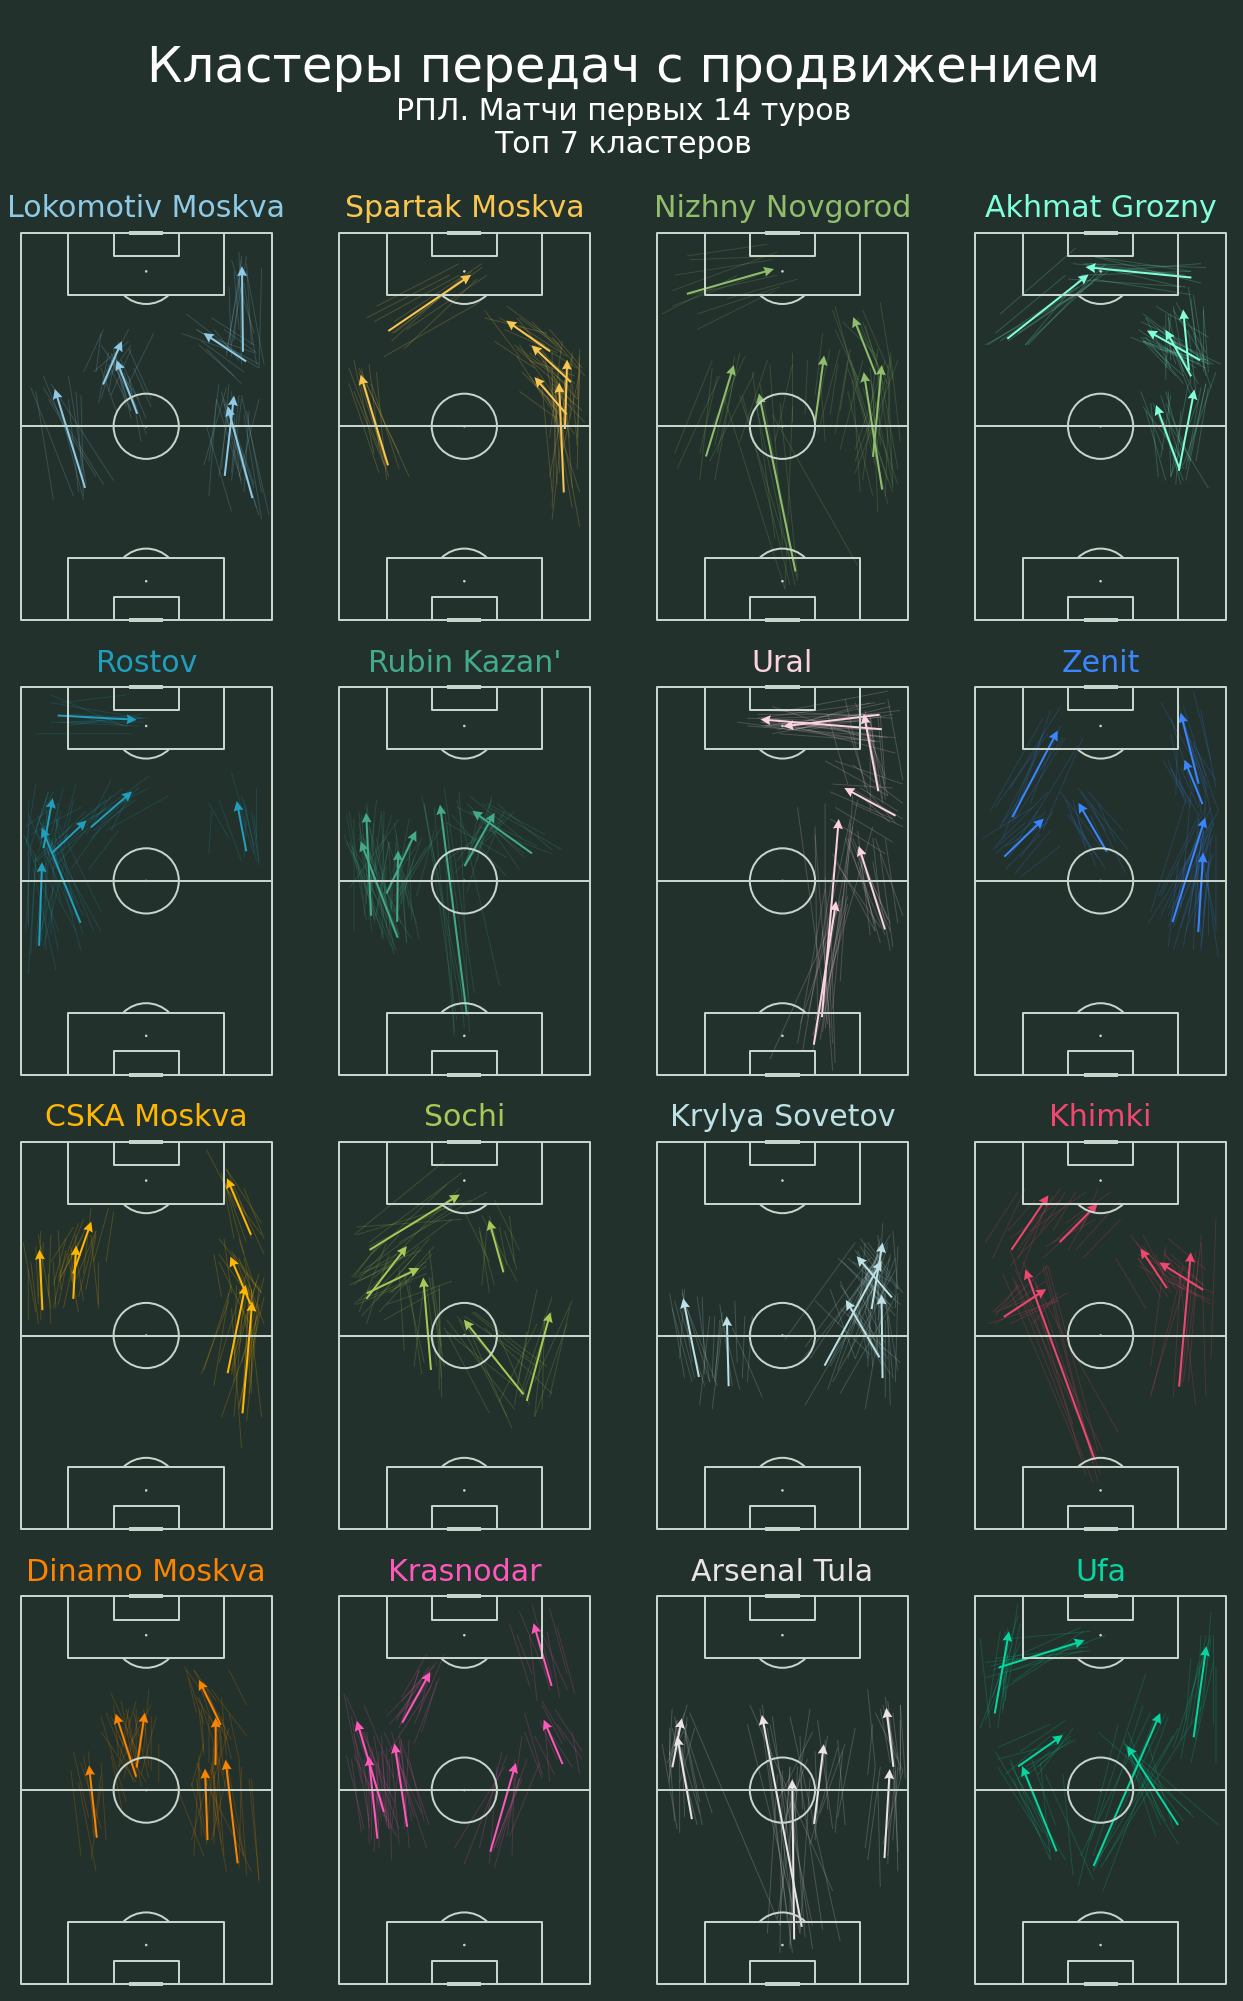

In [99]:
colors = [
    '#8ecae6', '#f9c74f', '#90be6d', '#80ffdb',
    '#219ebc', '#43aa8b', '#fad2e1', '#3a86ff',
    '#ffb703', '#a7c957', '#bee1e6', '#ef476f',
    '#fb8500', '#ff57bb', '#eae4e9', '#06d6a0',
]
    
# Example of the pitch grid is taken from https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_grid.html
pitch = VerticalPitch(
    line_zorder=2, # raise the pitch lines
    pitch_type='wyscout', 
    pitch_color='#22312b', 
    line_color='#c7d5cc'
)

# plot the 4 * 4 grid
fig, axs = pitch.grid(
    nrows=4, ncols=4,
    figheight=30,
    bottom=0.025,  # starts 2.5% in from the figure bottom
    # grid takes up 83% of the figure height
    # I calculated this so most of the figure is pitches
    # 1 - (bottom + endnote_height + endnote_space +
    # title_height + title_space) - 0.025 [space at top]
    grid_height=0.82,
    # reduced the amount of the figure height reserved
    # for the ax_endnote and ax_title since it is in
    # fractions of the figure height and the figure height
    # has increased. e.g. now the title_height is
    # 8% of the figheight (25).
    grid_width=0.95,  # the grid takes up 95% of the figwidth
    # 5% of the grid_height is the space between pitches.
    space=0.08,
    endnote_height=0.0, endnote_space=0.0,
    title_height=0.08, title_space=0.02,
    # Turn off the endnote/title axis. I usually do this after
    # I am happy with the chart layout and text placement
    axis=False
)
fig.set_facecolor('#22312b')

num_top_clusters = 7
teams = df_events['team_name'].unique()
for idx, ax in enumerate(axs['pitch'].flat):
    team = teams[idx]
    color = colors[idx]
    draw_progressive_passes_for_team(df_events, team, color, pitch, ax, num_top_clusters)

# title text
axs['title'].text(0.5, 0.65, f'Кластеры передач с продвижением', fontsize=50,
                  color='white', va='center', ha='center')
SUB_TEXT = ('РПЛ. Матчи первых 14 туров\n'
            f'Топ {num_top_clusters} кластеров')
axs['title'].text(0.5, 0.30, SUB_TEXT, fontsize=30,
                  color='white', va='center', ha='center')

In [100]:
fig.savefig(f'RPL-top-{num_top_clusters}-clusters-progressive-passes-normalized-2.png')